# Comparing chlorophyll data from two different sensors
> Updated August 2023 <br/>

Different ocean color sensors have been launched since 1997 to provide continuous global ocean color data. In the effort to provide long-term trend measurement values, newer sensors continued to be launched in replacement of the older.  Due to differences in sensor design and calibration, measurement values such as chlorophyll-a concentration values do not match during their periods of overlap, making it challenging to study long-term trends. 

### Objective

This tutorial will demonstrate how to compare mean chlorophyll-a concentration data from two sensors during overlapping time coverage.


### The tutorial demonstrates the following techniques
-   Downloading and saving a netcdf file from CoastWatch ERDDAP data server
-   Accessing and examining satellite data and metadata
-   Performing data wrangling including grouping, averaging, reformatting dates, etc.
-   Visualizing data on a map
-   Plotting two cholorphyll time series from the two sensors

### Datasets used

- Color Producing Agent (CPA) Chlorophyll daily data from MODIS sensor of Lake Erie (2002-2017) 

- Chlorophyll a from VIIRS (2018-2020)


## Import Packages

In [1]:
import urllib.request 
import xarray as xr 
import netCDF4 as nc
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap 
import warnings
warnings.filterwarnings('ignore')

## Download Lake Erie dailly MODIS data

We will download chlorophyll daily data from MODIS sensor from CoastWatch ERDDAP data server.  
(Dataset ID: **LE_CHL_MODIS_Daily**)

You should always examine the dataset in ERDDAP to check the date range, names of the variables and dataset ID, to make sure your griddap calls are correct.

CoastWatch MODIS Chlorophyll data page : 
https://coastwatch.glerl.noaa.gov/erddap/griddap/LE_CHL_MODIS_Daily.html



### Review of the ERDDAP data request URL
For our first exercise, we will download MODIS choloraphyll-a data with the following conditions:
* dates between August 2002 - August 2017  


* bounding coordinates with latitudes (41.005 to 42.995 ) and longitudes (-83.495 to -78.505) degrees respectively.

__The ERDDAP data request URL for this data subset is presented below.__ 

```
https://coastwatch.glerl.noaa.gov/erddap/griddap/LE_CHL_MODIS_Daily.nc?chlorophyll%5B(2002-08-07T19:05:00Z):1:(2017-10-22T18:00:00Z)%5D%5B(41.0051550293714):1:(42.9950003885447)%5D%5B(-83.4950003885448):1:(-78.505388156246)%5D
```

__The following table shows the component parts of the ERDDAP data request URL.__  

| Name   | Value| Description |
| ---:        |    :----   |          :--- |
| **base_url**    |    https://coastwatch.glerl.noaa.gov/erddap/griddap/  | ERDDAP URL for gridded datasets
| **datasetID** | LE_CHL_MODIS_Daily   | Unique ID for dataset from PolarWatch ERDDAP
| **file_type**  | .nc        | format of file to download (netCDF) |
| **query_start**   | ?        | Details of the query follow the ?  
| **variable_name**   | chlorophyll        | Variable from the dataset 
| **date_range**   | [(2002-08-07T19:05:00Z):1:(2017-10-22T18:00:00Z)]      |  Temporal range (2021-01-01)
| **spatial_range**   | [(41.0051550293714):1:(42.9950003885447)][(-83.4950003885448):1:(-78.505388156246)]  |  Lat and Lon ranges 


In [3]:
# Set ERDDAP URL 
url='https://coastwatch.glerl.noaa.gov/erddap/griddap/LE_CHL_MODIS_Daily.nc?chlorophyll%5B(2002-08-07T19:05:00Z):1:(2017-10-22T18:00:00Z)%5D%5B(41.0051550293714):1:(42.9950003885447)%5D%5B(-83.4950003885448):1:(-78.505388156246)%5D'

# Send data request to the ERDDAP URL and save to a file
urllib.request.urlretrieve(url, "e_chl_modis.nc")

('e_chl_modis.nc', <http.client.HTTPMessage at 0x127c0abd0>)

In [7]:
# Load the data using xarray
e_m_ds = xr.open_dataset('e_chl_modis.nc',decode_cf=False)

## Examine the downloaded data and metadata

Once the data are downloaded, it is important to examine the dataset structure, dimensions, coordinates, and variables to get information about the data for any data wranging work.

In [8]:
# Examine coordinates of the data
e_m_ds.coords

Coordinates:
  * time       (time) float64 1.029e+09 1.029e+09 ... 1.509e+09 1.509e+09
  * latitude   (latitude) float64 41.01 41.02 41.03 41.04 ... 42.98 42.99 43.0
  * longitude  (longitude) float64 -83.5 -83.49 -83.48 ... -78.53 -78.52 -78.51

In [9]:
# Examine time variable
e_m_ds.time

<xarray.DataArray 'time' (time: 506)>
array([1.028747e+09, 1.028830e+09, 1.028919e+09, ..., 1.508440e+09,
       1.508523e+09, 1.508695e+09])
Coordinates:
  * time     (time) float64 1.029e+09 1.029e+09 ... 1.509e+09 1.509e+09
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1.0287471e+09 1.5086952e+09]
    axis:                 T
    fraction_digits:      0
    ioos_category:        Time
    long_name:            Easten Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00
    units:                seconds since 1970-01-01T00:00:00Z

In [10]:
# Examine data variables
e_m_ds.data_vars

Data variables:
    chlorophyll  (time, latitude, longitude) float64 ...

In [9]:
# Examine the variable chlorophyll shape (dimension)
# Based on e_m_ds.coords, the dim corresponds to (time, latitude, longitude)
e_m_ds.chlorophyll.shape

(506, 200, 500)

## Reformat and clean data for data analysis

Once the data structure and data set are examined, the next step is to reformat and aggregate data into a format for the data analysis. 

In [1]:
# Create datetime array from time and time unit provided from the data
e_m_dates=nc.num2date(e_m_ds.time,e_m_ds.time.units, only_use_cftime_datetimes=False, 
                        only_use_python_datetimes=True )
# Examine the results
e_m_dates

NameError: name 'nc' is not defined

In [20]:
# Examine _FillValue from the metadata
e_m_ds.chlorophyll.attrs['_FillValue']

-999.0

In [21]:
# In chlorophyll array, replace -999 with nan
nan_e_m_ds_chlorophyll = e_m_ds.chlorophyll.where(e_m_ds.chlorophyll.values != e_m_ds.chlorophyll.attrs['_FillValue'])

#print(nan_e_m_ds_chlorophyll[0,100,:] )
#print(nan_e_m_ds_chlorophyll)
e_m_ds.chlorophyll

-999.0


##  Compute the Lake Erie August 2009 monthly mean of chlorophyll

In this exercise, we will compute the August, 2009 monthly mean of daily chlorophyll values from the daily chlorophyll values of our dataset.

In [24]:
# Create list of string contains 'year month day hours minutes seconds' 
d_list = []
[ d_list.append(dt.strftime("%Y %m %d %H %M %S")) for dt in e_m_dates]

mn, yr = '08' , '2009'
i_list = []

for n, d in enumerate(d_list):
    d_t = d.split()
    if d_t[0] == yr and d_t[1] == mn:
        # print( n, d_t)
        i_list.append(n)  # get all index of data for yr and mn
    
    #print(n, d)
#print(i_list)

# axis=0 is time line
chl_avg_img = nan_e_m_ds_chlorophyll.values[i_list[0]:i_list[-1]].mean(axis=0)
#print(chl_avg_img.shape)

## Plot Lake Erie August 2009 monthly mean of chlorophyll

First, we will set parameters needed for plotting and creating color map.  Then we will create a plot of monthly mean chlorophyll values.

In [16]:
# Compute number of colors 
levs = np.arange(np.nanmin(chl_avg_img), np.nanmax(chl_avg_img), 0.3)

# Examine number of colors needed for the plot 
len(levs)

# Set parameters for color map
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

# Set Colormap segments
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

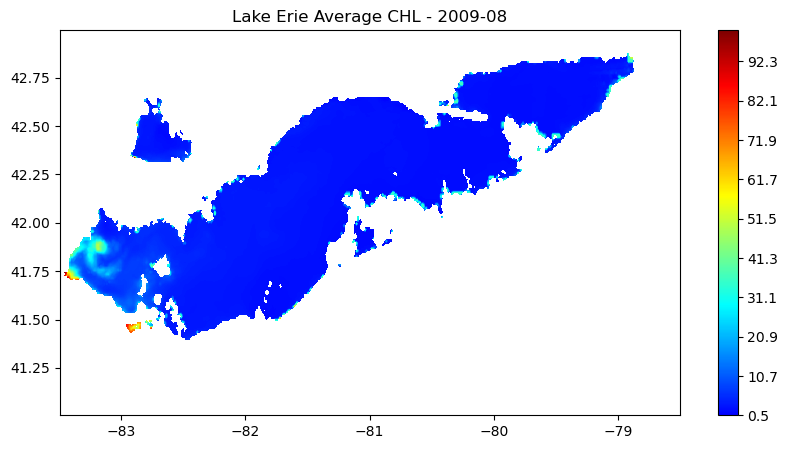

In [17]:
# Set plot size
plt.subplots(figsize=(10, 5))

# Plot monthly chlorophyll with longitudes and latitudes
plt.contourf(e_m_ds.longitude, e_m_ds.latitude, chl_avg_img, levs,cmap=cm)

# Print colorbar with color scale
plt.colorbar()

# Set plot title
plt.title("Lake Erie Average CHL - " + yr + '-' + mn)
plt.show()

## Compute chlorophyll monthly mean from 2002 to 2017

In the next exercise, we will compute montly means from 2002 to 2017 to examine the time series of monthly values of multiple years.  

The previous exercise involves computing mean values of chlorophyll for each grid cell.  For this exercise, we will compute temporal mean (averaging daily values to get monthly), but also compute sptail mean (averaging over grid cells).  This results in a value for each month at Lake Erie.

In [18]:
d_list = []
[ d_list.append(dt.strftime("%Y %m %d %H %M %S")) for dt in e_m_dates]

#print(min(d_list))
#print(max(d_list))
m_yr_list = []
[ m_yr_list.append(str(dt.year)) for dt in e_m_dates if str(dt.year) not in m_yr_list ]

print(m_yr_list)
print(len(m_yr_list))

mn_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
m_chl_avg_list = []
for yr in m_yr_list:
    for mn in mn_list:
        
        i_list = []
        for n, d in enumerate(d_list):
            d_t = d.split()
            #print(type(yr), type(mn), d_t)
            if d_t[0] == yr and d_t[1] == mn:
                #print( n, d_t)
                i_list.append(n)  # get all index of data for yr and mn
    
        #print(i_list, 'aaa')

        if i_list:
            #print('bbb')
            # axis=0 is time line
            m_chl_avg = np.nanmean(nan_e_m_ds_chlorophyll.values[i_list[0]:i_list[-1]],axis=(0,1,2))
            #print(i_list)
            #print('ccc', chl_avg)
        else:
            m_chl_avg = np.NAN
        #print(yr, mn, chl_avg)
        
        m_chl_avg_list.append(m_chl_avg)  # add each month mean data into list
print(len(m_chl_avg_list))
print(m_chl_avg_list)

['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
16
192
[nan, nan, nan, nan, nan, nan, nan, 5.435731696799938, 5.390267233342085, 8.081265781572409, nan, nan, nan, nan, nan, nan, nan, 6.781491128619841, 6.109469974086832, 4.314376310517935, 6.79798886383254, 7.093404713878546, nan, nan, nan, nan, nan, nan, nan, nan, nan, 5.368433526104296, 7.64127887019175, 10.885647119544341, nan, nan, nan, nan, nan, nan, nan, 5.840624163588643, 5.249259500793706, 4.616988228955723, 7.096526864254263, 4.819230418185895, nan, nan, nan, nan, nan, nan, nan, 4.510100122676393, 4.086877241390418, 8.282441959350821, nan, nan, nan, nan, nan, nan, nan, nan, nan, 6.047208513833891, 4.158334577045406, 5.306521407370655, 4.870477621191157, nan, nan, nan, nan, nan, nan, nan, nan, 4.399793136125678, 4.948825492811119, 6.928067277764852, 7.537945121660116, 10.463871652015316, nan, nan, nan, nan, nan, nan, nan, 5.468607769352359, 4.33143

## Plot montly mean chlorophyll values from 2002 to 2017

The time series plot shows Lake Erie's average monthly chlorophyll values for each month between 2002 and 2017.

In [2]:
x = np.linspace(2002, 2018,num=192)   # contains data from 2002 to 2017 (not 2018)

#units = e_m_ds.chlorophyll.attrs['units']

plt.figure(figsize=(12,5)) 
plt.plot(x,m_chl_avg_list,label='MODIS CHL',c='red',marker='.',linestyle='-')
plt.ylabel('Chl-a (mg/m^3)')
plt.legend()

NameError: name 'np' is not defined

## Get Lake Erie monthly chlorophyll data from different sensor, VIIRS

The VIIRS satellite dataset includes monthly chlorophyll values from 2018 to present. We will download and reformat the data to compare with the previously computed monthly chlorophyll data of the Lake Erie.


In [3]:
url2='https://coastwatch.glerl.noaa.gov/erddap/griddap/LE_CHL_VIIRS_Monthly_Avg.nc?Chlorophyll%5B(2018-05-15T12:00:00Z):1:(2022-09-15T12:00:00Z)%5D%5B(41.2690208353804):1:(43.017997272827)%5D%5B(-83.6574899492178):1:(-78.4429490894234)%5D'
urllib.request.urlretrieve(url2, "e_viirs_chl.nc")

NameError: name 'urllib' is not defined

In [21]:
# Open the dataset using xarray
e_v_ds = xr.open_dataset('e_viirs_chl.nc',decode_cf=False)

In [22]:
# Examine metadata of the data set
print(e_v_ds)

<xarray.Dataset>
Dimensions:      (time: 53, latitude: 271, longitude: 806)
Coordinates:
  * time         (time) float64 1.526e+09 1.529e+09 ... 1.661e+09 1.663e+09
  * latitude     (latitude) float64 41.27 41.28 41.28 ... 43.01 43.01 43.02
  * longitude    (longitude) float64 -83.66 -83.65 -83.64 ... -78.45 -78.44
Data variables:
    Chlorophyll  (time, latitude, longitude) float32 ...
Attributes: (12/35)
    cdm_data_type:                  Grid
    colorBarMaximum:                30.0
    colorBarMinimum:                1.0
    colorBarScale:                  Log
    Conventions:                    CF-1.6, COARDS, ACDD-1.3
    Easternmost_Easting:            -78.4429490894234
    ...                             ...
    summary:                        Color Producing Agent (CPA) Chlorophyll, ...
    testOutOfDate:                  now-58days
    time_coverage_end:              2022-09-15T12:00:00Z
    time_coverage_start:            2018-05-15T12:00:00Z
    title:                     

In [23]:
nan_e_v_ds_chlorophyll = e_v_ds.Chlorophyll.where(e_v_ds.Chlorophyll.values != e_v_ds.Chlorophyll.attrs['_FillValue'])

v_chl_avg = np.nanmean(nan_e_v_ds_chlorophyll,axis=(1,2))
print(v_chl_avg)
print(len(v_chl_avg))

[ 7.387662   7.130833   6.8531957  7.067971  10.981218   9.158773
 13.29338    9.700653  13.87522   37.8129    17.29175   14.630282
 10.530294   8.1118765  6.0679684  7.7413135  8.563966  18.578035
 13.02914    9.297082  13.149483  14.124588  12.059988  12.409704
  8.531175   6.5784163  4.954806   6.5634985  7.719488  11.749591
 14.757857  16.201027  10.846249  11.817226  15.175478   9.953331
  9.3959055  5.0962305  4.7101736  6.511713  10.5009165  8.693387
 10.755935  25.140661  14.031336  17.865644  16.326204   8.967016
  8.982615   4.526909   4.958596   6.2696676  6.026227 ]
53


In [24]:
# Reformat the data 
e_v_dates=nc.num2date(e_v_ds.time,e_v_ds.time.units, only_use_cftime_datetimes=False, 
                        only_use_python_datetimes=True )
e_v_dates 


array([real_datetime(2018, 5, 15, 12, 0),
       real_datetime(2018, 6, 15, 12, 0),
       real_datetime(2018, 7, 15, 12, 0),
       real_datetime(2018, 8, 15, 12, 0),
       real_datetime(2018, 9, 15, 12, 0),
       real_datetime(2018, 10, 15, 12, 0),
       real_datetime(2018, 11, 15, 12, 0),
       real_datetime(2018, 12, 15, 12, 0),
       real_datetime(2019, 1, 15, 12, 0),
       real_datetime(2019, 2, 15, 12, 0),
       real_datetime(2019, 3, 15, 12, 0),
       real_datetime(2019, 4, 15, 12, 0),
       real_datetime(2019, 5, 15, 12, 0),
       real_datetime(2019, 6, 15, 12, 0),
       real_datetime(2019, 7, 15, 12, 0),
       real_datetime(2019, 8, 15, 12, 0),
       real_datetime(2019, 9, 15, 12, 0),
       real_datetime(2019, 10, 15, 12, 0),
       real_datetime(2019, 11, 15, 12, 0),
       real_datetime(2019, 12, 15, 12, 0),
       real_datetime(2020, 1, 15, 12, 0),
       real_datetime(2020, 2, 15, 12, 0),
       real_datetime(2020, 3, 15, 12, 0),
       real_datetime(2020, 4

In [25]:
v_chl_avg = np.nanmean(nan_e_v_ds_chlorophyll.values,axis=(1,2))
v_chl_avg

array([ 7.387662 ,  7.130833 ,  6.8531957,  7.067971 , 10.981218 ,
        9.158773 , 13.29338  ,  9.700653 , 13.87522  , 37.8129   ,
       17.29175  , 14.630282 , 10.530294 ,  8.1118765,  6.0679684,
        7.7413135,  8.563966 , 18.578035 , 13.02914  ,  9.297082 ,
       13.149483 , 14.124588 , 12.059988 , 12.409704 ,  8.531175 ,
        6.5784163,  4.954806 ,  6.5634985,  7.719488 , 11.749591 ,
       14.757857 , 16.201027 , 10.846249 , 11.817226 , 15.175478 ,
        9.953331 ,  9.3959055,  5.0962305,  4.7101736,  6.511713 ,
       10.5009165,  8.693387 , 10.755935 , 25.140661 , 14.031336 ,
       17.865644 , 16.326204 ,  8.967016 ,  8.982615 ,  4.526909 ,
        4.958596 ,  6.2696676,  6.026227 ], dtype=float32)

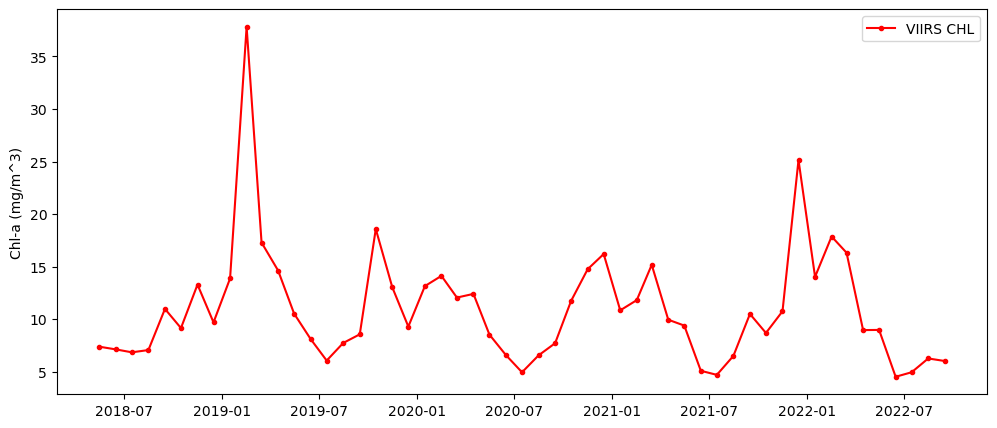

In [26]:
plt.figure(figsize=(12,5)) 
plt.plot(e_v_dates,v_chl_avg,label='VIIRS CHL',c='red',marker='.',linestyle='-')
plt.ylabel('Chl-a (mg/m^3)')
plt.legend()

In [27]:
#e_v_ds.close()
!jupyter nbconvert --to html GL_python_tutorial2.ipynb

[NbConvertApp] Converting notebook GL_python_tutorial2.ipynb to html
[NbConvertApp] Writing 819692 bytes to GL_python_tutorial2.html
